In [1]:
import numpy  as np
import pandas as pd
import random
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

# Реализация обучения FCN
В этом модуле мы создадим нашу первую FCN модель для задачи Семантической Сегментации. А также построим пайплайн обучения этой модели.

Обучение такой модели на реальных данных займет достаточно длительное время. Поэтому мы будем обучаться на очень маленьком датасете, состоящем из одной картинки (и её зеркальной копии). При таком подходе мы столкнемся с проблемой переобучения ("запоминание" обучающей выборки и отсутствие обобщения), но ничего страшного. Нам лишь нужно будет протестировать, что пайплайн и модель работают корректно.

## Подготовка датасета

### Загрузка и подготовка входного изображения

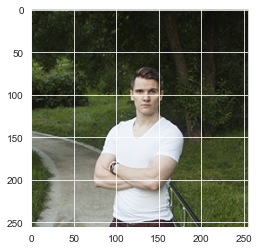

In [2]:
img = imageio.v2.imread('img/me_256.png')
img = img.astype(np.float32) / 255
_=plt.imshow(img)

### Загрузка и подготовка карты сегментации человек/фон
То же самое касается файла 'me_gt_256.png'.

После загрузки мы приводим 3 канала RGB к одному каналу путём усреднения.

Это наша Ground-Truth карта сегментации, размеченная кем-то (мною) вручную.
Значение `'0'` в ней означает класс "фон", значение `'1'` -- класс "человек"

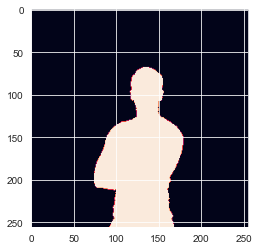

In [4]:
gt = imageio.v2.imread('img/me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[..., None]
_=plt.imshow(gt[...,0])

### Подготовка обучающего датасета
Наша цель создать и протестировать пайплайн для обучения FCN модели, включая данные, модель, лосс и т.д.

Поэтому для простоты эксперимента возьмем очень простой датасет, состоящий из двух изображений: загруженная картинка и её зеркально отраженная копия.

Индексирование `'::-1'` означает взять все элементы в обратном порядке.

При обучении на таком маленьком датасете модель переобучится, но в данном примере нас это не будет беспокоить. Наша цель - отладить пайплайн, поэтому тестировать будем на том же, на чём и обучались.

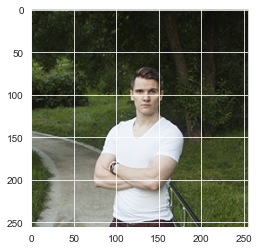

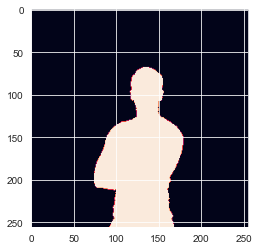

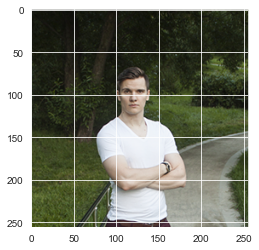

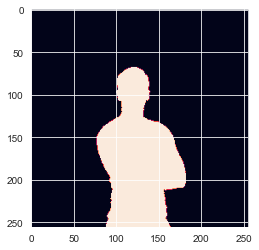

(<matplotlib.image.AxesImage at 0x1d38b395300>, None)

In [5]:
train_x = np.stack((img, img[:,::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

plt.imshow(train_x[0]), plt.show()
plt.imshow(train_y[0][...,0]), plt.show()
plt.imshow(train_x[1]), plt.show()
plt.imshow(train_y[1][...,0]), plt.show()

## Пайплайн обучения FCN

### Создание FCN модели
Модель создаётся путём наслелования от `tf.keras.Model`.

В методе `Model.__init__` создаются слои.

В методе `Model.call` производится инференс с использованием созданных слоёв и других функций TensorFlow

In [6]:
NUM_EPOCHS = 100

class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation=None)
        self.pool = tf.keras.layers.MaxPool2D((2, 2))

    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.pool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = tf.image.resize(out, (x.shape[1], x.shape[2]), tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out

model = Model()

### Подготовка модели к обучению
В качестве лосса используется бинарная кросс-энтропия (BinaryCrossentropy).
В лоссе автоматически происходит суммирование по всем измерениям.

In [7]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

### Обучение модели

In [8]:
history = model.fit(train_x, train_y, batch_size=1, epochs=NUM_EPOCHS)

Epoch 1/100
2/2 [==============================] - 2s 456ms/step - loss: 0.6820
Epoch 2/100
2/2 [==============================] - 1s 456ms/step - loss: 0.6454
Epoch 3/100
2/2 [==============================] - 1s 435ms/step - loss: 0.5621
Epoch 4/100
2/2 [==============================] - 1s 440ms/step - loss: 0.3675
Epoch 5/100
2/2 [==============================] - 1s 408ms/step - loss: 0.2615
Epoch 6/100
2/2 [==============================] - 1s 393ms/step - loss: 0.2346
Epoch 7/100
2/2 [==============================] - 1s 637ms/step - loss: 0.2053
Epoch 8/100
2/2 [==============================] - 1s 663ms/step - loss: 0.2188
Epoch 9/100
2/2 [==============================] - 1s 610ms/step - loss: 0.2178
Epoch 10/100
2/2 [==============================] - 1s 537ms/step - loss: 0.2059
Epoch 11/100
2/2 [==============================] - 1s 472ms/step - loss: 0.2056
Epoch 12/100
2/2 [==============================] - 1s 548ms/step - loss: 0.2062
Epoch 13/100
2/2 [===================

### График зависимости лосса от эпохи

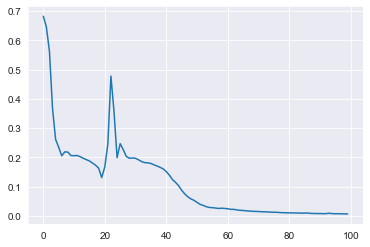

In [9]:
plt.plot(history.history['loss'])

### Результат предсказания на входной картинке

1/1 [==============================] - 0s 179ms/step


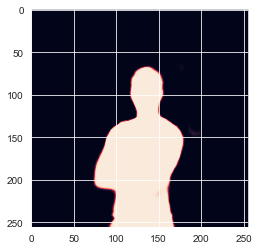

In [10]:
out = model.predict(img[None, ...])
_=plt.imshow(out[0, ..., 0])

### Результат предсказания для всех картинок
По предсказанию сети получается карта сегментации с помощью порога.

Далее она отображается поверх исходной картинки.

1/1 [==============================] - 0s 93ms/step


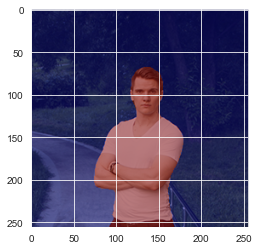

1/1 [==============================] - 0s 93ms/step


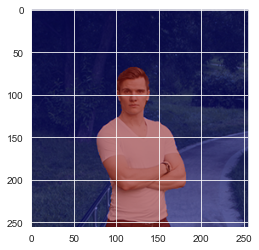

In [11]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('jet')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()

# Реализация модернизированной FCN сети

## Подготовка датасета

### Загрузка и подготовка входного изображения

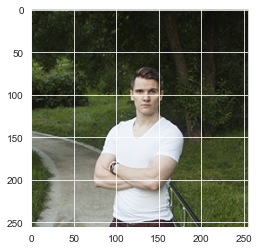

In [5]:
img = imageio.v3.imread('img/me_256.png')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

### Загрузка и подготовка карты сегментации человек/фон

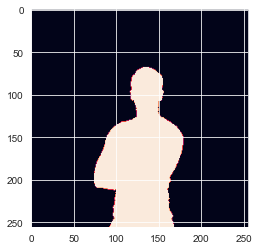

In [6]:
gt = imageio.v3.imread('img/me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[...,None]
_=plt.imshow(gt[...,0])

### Подготовка обучающего датасета
Наша цель создать пайплайн для обучения, включая данные, модель, лосс и т.д.

Поэтому для простоты возьмем очень простой датасет, состоящий из двух изображений: загруженная картинка и её зеркально отраженная копия.

При обучении на таком маленьком датасете модель переобучится, но в данном примере нас это не будет беспокоить. Наша цель - отладить пайплайн, поэтому тестировать будем на том же, на чём и обучались

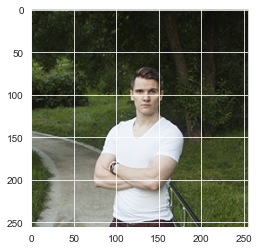

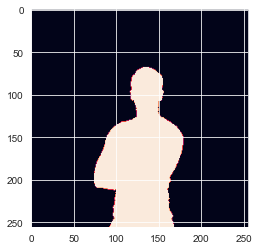

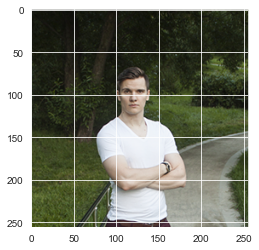

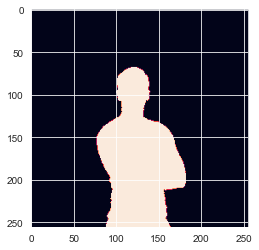

(<matplotlib.image.AxesImage at 0x1c97fb5d4b0>, None)

In [7]:
train_x = np.stack((img, img[:,::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

plt.imshow(train_x[0]), plt.show()
plt.imshow(train_y[0][...,0]), plt.show()
plt.imshow(train_x[1]), plt.show()
plt.imshow(train_y[1][...,0]), plt.show()

## Пайплайн обучения FCN

### Создание FCN модели

Для создания модели создадим собственный класс, наследованный от tf.keras.Model. Ранее мы использовали лишь свёртки и пулинги для извлечения признаков и понижения пространственных размерностий. Это был наш Энкодер.
В качестве Декодера у нас был простой Upscale слой, который просто расширял изображение до нужного размера. Теперь же давайте реализуем более качественный Декодер с использованием слоёв для повышения разрешения.

В примере ниже будем использовать Unpooling (в керасе это делает слой tf.keras.layers.UpSampling2D) перемежающиийся со свёрточными слоями.

Для понижения размерности используются свёртки со страйдом. Для повышения размерности - Unpooling (nearest neighbour)

Модель создаётся путём наслелования от `tf.keras.Model`.

В методе `Model.__init__` создаются слои.

В методе `Model.call` производится инференс с использованием созданных слоёв и других функций TensorFlow

In [8]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')

        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')

        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')

        self.conv6 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')

        self.conv7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')

        self.conv9 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')

        self.unpool = tf.keras.layers.UpSampling2D((2, 2))

    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)

        out = self.conv7(out)
        out = self.conv8(out)
        out = self.unpool(out)

        out = self.conv9(out)
        out = self.conv10(out)
        out = self.unpool(out)

        out = self.conv11(out)
        out = self.conv12(out)

        return out

model = Model()

### Параметры обучения

In [9]:
NUM_EPOCHS = 100

### Подготовка модели к обучению
В качестве лосса используется бинарная кросс-энтропия (BinaryCrossentropy).
В лоссе автоматически происходит суммирование по всем измерениям.

In [10]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

### Обучение модели

In [11]:
history = model.fit(train_x, train_y, batch_size=1, epochs=NUM_EPOCHS)

Epoch 1/100
2/2 [==============================] - 4s 1s/step - loss: 0.6896
Epoch 2/100
2/2 [==============================] - 3s 2s/step - loss: 0.6712
Epoch 3/100
2/2 [==============================] - 4s 2s/step - loss: 0.6430
Epoch 4/100
2/2 [==============================] - 3s 1s/step - loss: 0.4373
Epoch 5/100
2/2 [==============================] - 3s 1s/step - loss: 0.3083
Epoch 6/100
2/2 [==============================] - 3s 2s/step - loss: 0.3156
Epoch 7/100
2/2 [==============================] - 4s 2s/step - loss: 0.2811
Epoch 8/100
2/2 [==============================] - 4s 2s/step - loss: 0.2378
Epoch 9/100
2/2 [==============================] - 3s 2s/step - loss: 0.2363
Epoch 10/100
2/2 [==============================] - 3s 2s/step - loss: 0.2183
Epoch 11/100
2/2 [==============================] - 4s 2s/step - loss: 0.2012
Epoch 12/100
2/2 [==============================] - 3s 1s/step - loss: 0.1872
Epoch 13/100
2/2 [==============================] - 3s 1s/step - loss: 0.

### График зависимости лосса от эпохи

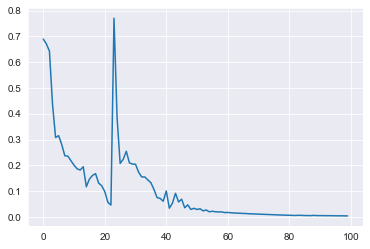

In [12]:
plt.plot(history.history['loss'])

### Результат предсказания на входной картинке

1/1 [==============================] - 0s 369ms/step


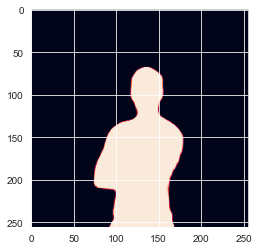

In [13]:
out = model.predict(img[None, ...])
_=plt.imshow(out[0, ..., 0])

### Результат предсказания для всех картинок
По предсказанию сети получается карта сегментации с помощью порога.

Далее она отображается поверх исходной картинки.

1/1 [==============================] - 0s 298ms/step


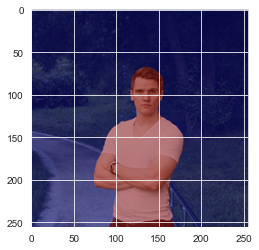

1/1 [==============================] - 0s 358ms/step


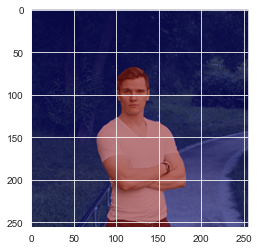

In [14]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('jet')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()

# Реализация FCN сети на основе архитектуры UNet

Мы создадим еще более качественную FCN модель на основе архитектуры UNet. Кроме использовавшихся ранее слоёв, здесь также будут участвовать Skipped Connections (проброшенные связи).


<img src="img/unet.jpg" width="1000">

## Подготовка датасета

### Загрузка и подготовка входного изображения

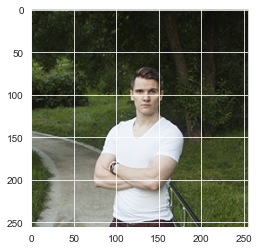

In [4]:
img = imageio.v3.imread('img/me_256.png')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

### Загрузка и подготовка карты сегментации человек/фон

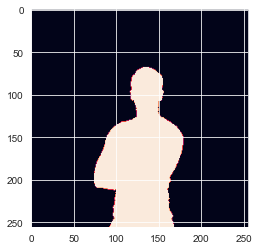

In [5]:
gt = imageio.v3.imread('img/me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[...,None]
_=plt.imshow(gt[...,0])

### Подготовка обучающего датасета
Наша цель создать пайплайн для обучения, включая данные, модель, лосс и т.д.

Поэтому для простоты возьмем очень простой датасет, состоящий из двух изображений: загруженная картинка и её зеркально отраженная копия.

При обучении на таком маленьком датасете модель переобучится, но в данном примере нас это не будет беспокоить. Наша цель - отладить пайплайн, поэтому тестировать будем на том же, на чём и обучались

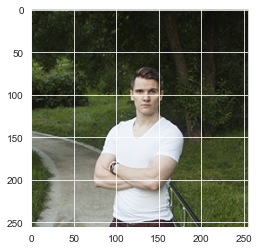

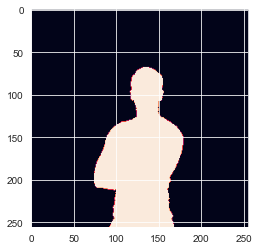

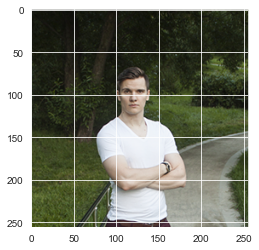

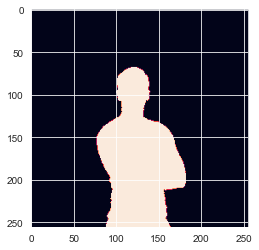

(<matplotlib.image.AxesImage at 0x27a23a8f970>, None)

In [6]:
train_x = np.stack((img, img[:,::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

plt.imshow(train_x[0]), plt.show()
plt.imshow(train_y[0][...,0]), plt.show()
plt.imshow(train_x[1]), plt.show()
plt.imshow(train_y[1][...,0]), plt.show()

## Пайплайн обучения UNet

### Создание UNet модели
Так как UNet имееет разветвления, мы не сможем создать её с помощью `tf.keras.Sequential`. Остаётся либо создать свой собственный класс, либо использовать функциональный API. Так как граф у нас будет статический (без каких-то условных ветвлений), и нам потом желательно визуализировать полученный граф, чтобы проверить, что мы всё соединили правильно, мы будем использовать именно функциональный API.

В архитектуре UNet для понижения размерности используется MaxPooling, а для повышения -- Conv2DTranspose (Транспонированная свёртка, Upconv). Кроме того, присутствуют проброшенные связи (skipped connections): некоторые тензоры из Энкодера конкатенируются по канальному измерению (axis=3) с тензорами из Декодера. В остальном эта модель очень похожа на обычную Encoder-Decoder нейросеть из предыдущего практического урока.

В отличие от классической UNet архитектуры, мы во всех слоях будем использовать `padding='same'`, чтобы избавиться от необходимости делать crop при конкатинации тензоров из разных участков сети.

In [2]:
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2), activation='relu')(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', strides=(2, 2), activation='relu')(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', strides=(2, 2), activation='relu')(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', strides=(2, 2), activation='relu')(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [3]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Параметры обучения

In [13]:
NUM_EPOCHS = 100

### Подготовка модели к обучению
В качестве лосса используется бинарная кросс-энтропия (BinaryCrossentropy).
В лоссе автоматически происходит суммирование по всем измерениям.

In [8]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

### Обучение модели

In [14]:
history = model.fit(train_x, train_y, batch_size=1, epochs=NUM_EPOCHS)

Epoch 1/100
2/2 [==============================] - 5s 3s/step - loss: 0.0801
Epoch 2/100
2/2 [==============================] - 6s 3s/step - loss: 0.0759
Epoch 3/100
2/2 [==============================] - 5s 2s/step - loss: 0.0703
Epoch 4/100
2/2 [==============================] - 6s 3s/step - loss: 0.0662
Epoch 5/100
2/2 [==============================] - 9s 5s/step - loss: 0.0623
Epoch 6/100
2/2 [==============================] - 9s 4s/step - loss: 0.0590
Epoch 7/100
2/2 [==============================] - 9s 5s/step - loss: 0.0565
Epoch 8/100
2/2 [==============================] - 10s 6s/step - loss: 0.0529
Epoch 9/100
2/2 [==============================] - 8s 4s/step - loss: 0.0510
Epoch 10/100
2/2 [==============================] - 5s 2s/step - loss: 0.0487
Epoch 11/100
2/2 [==============================] - 8s 4s/step - loss: 0.0477
Epoch 12/100
2/2 [==============================] - 9s 4s/step - loss: 0.0438
Epoch 13/100
2/2 [==============================] - 9s 4s/step - loss: 0

### График зависимости лосса от эпохи

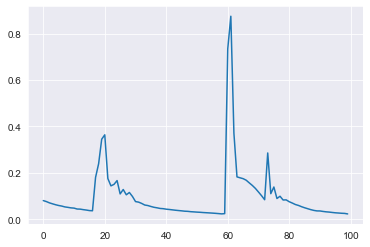

In [15]:
plt.plot(history.history['loss'])

### Результат предсказания на входной картинке

1/1 [==============================] - 0s 474ms/step


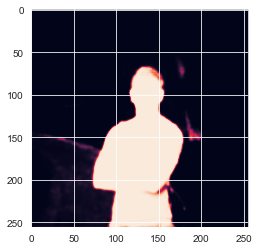

In [16]:
out = model.predict(img[None, ...])
_=plt.imshow(out[0, ..., 0])

### Результат предсказания для всех картинок
По предсказанию сети получается карта сегментации с помощью порога.

Далее она отображается поверх исходной картинки.

1/1 [==============================] - 0s 483ms/step


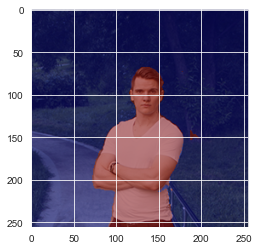

1/1 [==============================] - 1s 696ms/step


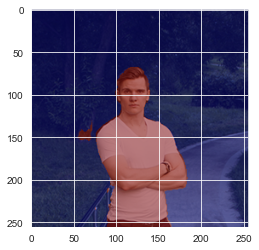

In [17]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('jet')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()

# Реализация FCN сети на основе блока ASPP

Мы создадим еще еще одну сегментационную FCN модель на основе блока ASPP (Atrous Spatial Pyramid Pooling), который основан на дилатационных свёртках (Atrous Conv, Dilated Conv)

<img src="img/aspp.jpg" width="1000">

## Подготовка датасета

### Загрузка и подготовка входного изображения

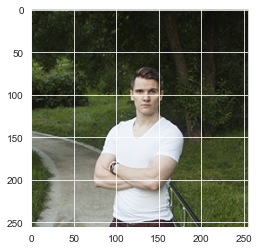

In [18]:
img = imageio.v3.imread('img/me_256.png')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

### Загрузка и подготовка карты сегментации человек/фон

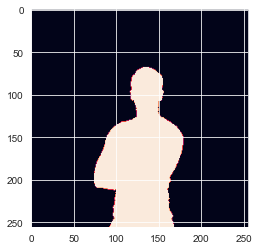

In [19]:
gt = imageio.v3.imread('img/me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[...,None]
_=plt.imshow(gt[...,0])

### Подготовка обучающего датасета
Наша цель создать пайплайн для обучения, включая данные, модель, лосс и т.д.

Поэтому для простоты возьмем очень простой датасет, состоящий из двух изображений: загруженная картинка и её зеркально отраженная копия.

При обучении на таком маленьком датасете модель переобучится, но в данном примере нас это не будет беспокоить. Наша цель - отладить пайплайн, поэтому тестировать будем на том же, на чём и обучались

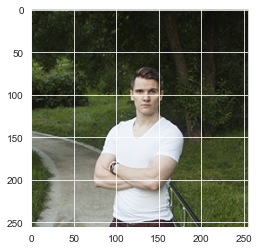

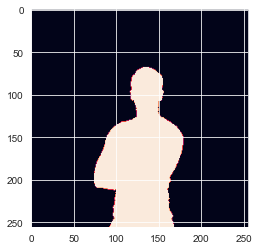

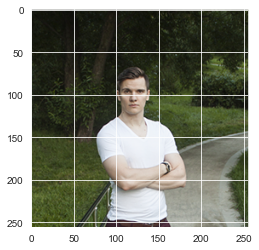

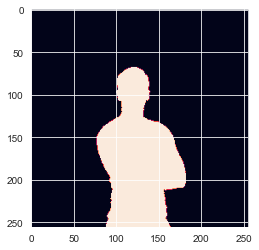

(<matplotlib.image.AxesImage at 0x27a23467d60>, None)

In [20]:
train_x = np.stack((img, img[:,::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

plt.imshow(train_x[0]), plt.show()
plt.imshow(train_y[0][...,0]), plt.show()
plt.imshow(train_x[1]), plt.show()
plt.imshow(train_y[1][...,0]), plt.show()

## Пайплайн обучения ASPP

### Создание ASPP модели
В этом примере мы будем создавать модель `ASPPNet` через собственный класс, наследованный от `tf.keras.Model`. Кроме того, будем использовать возможность модульного создания нейросетей. Сначала создадим отдельно модель для ASPP блока (блок, который содержит только дилатационные свёртки и применяется между энкодером и декодером), которая по сути будет являться самостоятельным слоем. А затем создадим финальную модель `ASPPNet`, в который `ASPPBlock` будет использоваться как слой между Энкодером и Декодером.

В ASPP блоке (`ASPPBlock`) ко входному тензору параллельно применяются обычная свёртка 1x1 и несколько дилатационных свёрток. Затем все эти резульаты конкатенируются. Далее "перемешиваем" каналы полученного тензора с помощью еще одной свёртки 1x1.

В финальной ASPP модели (`ASPPNet`) в качестве Энкодера будем использовать стандартные свёртки и пулинги. Далее в боттлнеке (в середине сети) применим слой ASPPBlock. А в Декодере будем использовать более простую архитектуру: меньше свёрток, повышение размерности с помощью двух билинейных интерполяций (`tf.image.resize`). Кроме того, в сети присутствуют две проброшенные связи.

In [26]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out

class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out

model = ASPPNet()

### Параметры обучения

In [27]:
NUM_EPOCHS = 100

### Подготовка модели к обучению
В качестве лосса используется бинарная кросс-энтропия (BinaryCrossentropy).
В лоссе автоматически происходит суммирование по всем измерениям.

In [28]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

### Обучение модели

In [29]:
history = model.fit(train_x, train_y, batch_size=1, epochs=NUM_EPOCHS)

Epoch 1/100
2/2 [==============================] - 6s 1s/step - loss: 0.6621
Epoch 2/100
2/2 [==============================] - 3s 2s/step - loss: 11.0762
Epoch 3/100
2/2 [==============================] - 3s 2s/step - loss: 0.6700
Epoch 4/100
2/2 [==============================] - 3s 1s/step - loss: 0.6464
Epoch 5/100
2/2 [==============================] - 3s 2s/step - loss: 0.5298
Epoch 6/100
2/2 [==============================] - 3s 1s/step - loss: 0.4488
Epoch 7/100
2/2 [==============================] - 3s 1s/step - loss: 0.3489
Epoch 8/100
2/2 [==============================] - 3s 2s/step - loss: 0.2569
Epoch 9/100
2/2 [==============================] - 3s 1s/step - loss: 0.2119
Epoch 10/100
2/2 [==============================] - 3s 1s/step - loss: 0.1884
Epoch 11/100
2/2 [==============================] - 3s 1s/step - loss: 0.1474
Epoch 12/100
2/2 [==============================] - 3s 2s/step - loss: 0.3224
Epoch 13/100
2/2 [==============================] - 3s 1s/step - loss: 0

### График зависимости лосса от эпохи

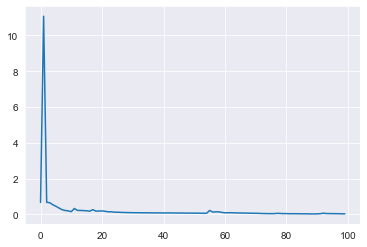

In [30]:
plt.plot(history.history['loss'])

### Результат предсказания на входной картинке

1/1 [==============================] - 0s 454ms/step


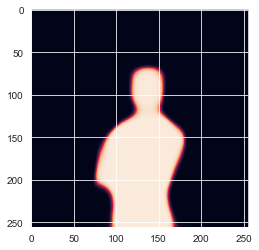

In [31]:
out = model.predict(img[None, ...])
_=plt.imshow(out[0, ..., 0])

### Результат предсказания для всех картинок
По предсказанию сети получается карта сегментации с помощью порога.

Далее она отображается поверх исходной картинки.

1/1 [==============================] - 0s 228ms/step


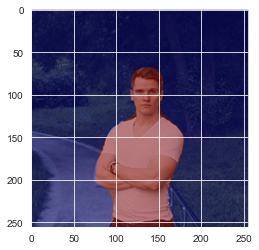

1/1 [==============================] - 0s 250ms/step


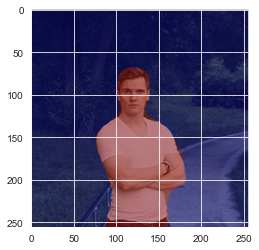

In [32]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('jet')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()